In [1]:
import xarray as xr
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs              # Geographic maps 
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import scienceplots                 # Well-defined plot styles
plt.style.use(["science", "notebook"])
from tqdm import tqdm
import metpy
import sys
sys.path.append('../build/')
from scipy.interpolate import splrep, splev

## Event Plots

Extreme events were determined to be over the 99.9th percentile for total precipitation. Only investigating __land__ events.

In [2]:
def parse_events(file):
    ds = xr.load_dataset(file)
    df = pl.from_pandas(
        (
            ds
            # ds.where((ds.lat > -60) & (ds.lat < 80), drop=True)
            .drop_dims(['lat', 'lon'])
            # .drop_vars('quantile')
            .to_dataframe()
            .reset_index()
        )
    ).filter(
        (pl.col('start_lat') > -66) & 
        (pl.col('start_lat') < 70) & 
        (pl.col('duration') < 20)
    ).with_columns([
        pl.col('duration').cast(pl.Int16),
        pl.col('start_date').dt.year().alias('year'),
        ]).sort(pl.col('start_date'))
    n_events = len(df)
    return df, n_events
dfl, n_land = parse_events('../../data/land_only/TPV_999_land.nc')
dfa, n_all = parse_events('../../data/land_and_ocean/TPV_999.nc')

## Distribution of land events

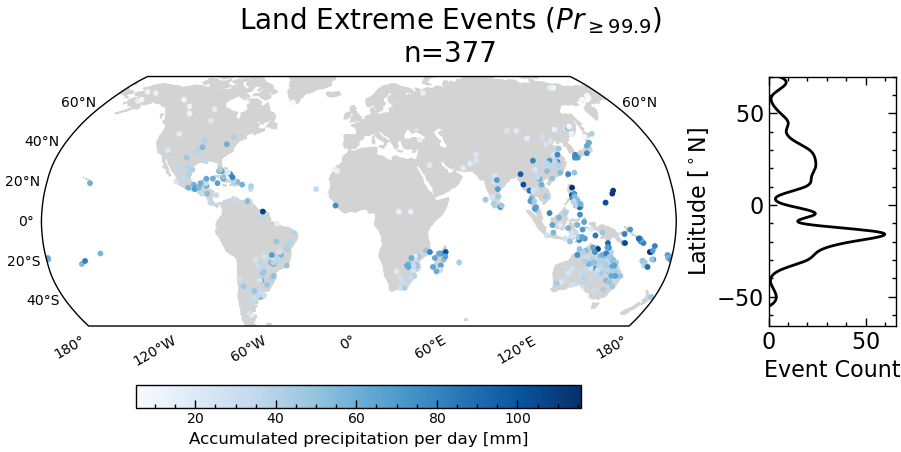

In [3]:
import matplotlib.transforms as transforms
fig = plt.figure(figsize=(9, 4.5), constrained_layout=True)
gs = fig.add_gridspec(1,2, width_ratios=[1, 0.2])  # left plot spatial, right plot signifigance
# First plot
ax0 = fig.add_subplot(gs[0], projection=ccrs.Robinson())
im = ax0.scatter(
    dfl['longitude'],
    dfl['latitude'],
    c=dfl['PPG']*1000,
    s=10,
    cmap='Blues',
    transform=ccrs.PlateCarree()
)
cb = plt.colorbar(im, orientation="horizontal", pad=0.01, shrink=0.7)
cb.ax.tick_params(labelsize=10)
cb.set_label(label='Accumulated precipitation per day [mm]', fontsize=12)


ax0.add_feature(cfeature.LAND, color='lightgrey')
gl = ax0.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True, which='both',
    linewidth=1, color='k', alpha=1, linestyle='--'
    )
gl.right_labels = None
gl.top_labels = None
gl.xlines = None
gl.ylines = None
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax0.xaxis.set_major_formatter(lon_formatter)
ax0.yaxis.set_major_formatter(lat_formatter)
# Increase the ticksize
gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}
# Longitude distribution of events
ax1 = fig.add_subplot(gs[1])
lat_bins = np.linspace(-90, 90, int(180/5)+1)
lat_bin_idx = np.digitize(dfl['start_lat'], lat_bins)
lat_binned = (
    dfl
    .with_columns(pl.Series('lat_bin', lat_bins[lat_bin_idx]).alias('lat_bin'))
    # dfl.with_columns(pl.col('latitude').round().alias('lat_bin'))
    .group_by('lat_bin').agg(pl.count())
    .sort('lat_bin')
)
xnew = np.linspace(-66, 70, 300)  
spl = splrep(lat_binned['lat_bin'], lat_binned['count'])
ax1.plot(splev(xnew, spl), xnew, color='k')
ax1.set_xlabel('Event Count')
ax1.set_ylabel('Latitude [$^\circ$N]')
ax1.set_xlim(0, None)
ax1.set_ylim(-66, 70)
fig.suptitle('Land Extreme Events ($Pr_{\geq99.9}$)\nn='+str(n_land), fontsize=20)
plt.savefig('../../output/figures/land_extremes.png', dpi=300, bbox_inches='tight')
plt.show()

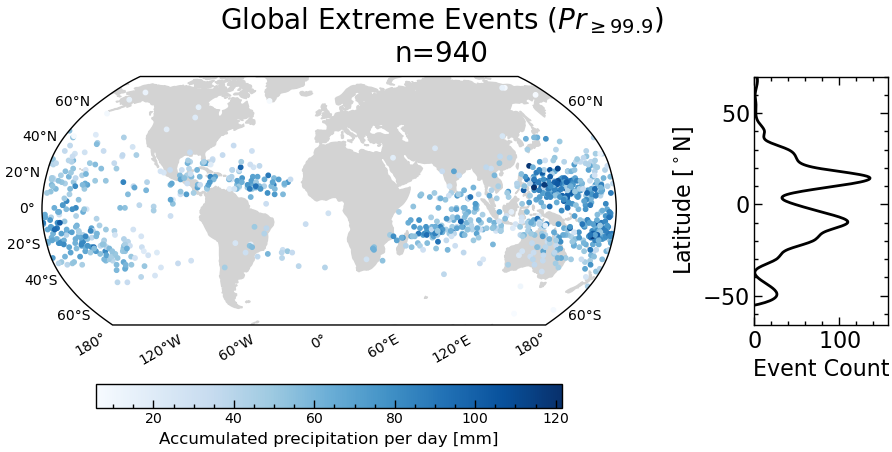

In [4]:
import matplotlib.transforms as transforms
fig = plt.figure(figsize=(9, 4.5), constrained_layout=True)
gs = fig.add_gridspec(1,2, width_ratios=[1, 0.2])  # left plot spatial, right plot signifigance
# First plot
ax0 = fig.add_subplot(gs[0], projection=ccrs.Robinson())
im = ax0.scatter(
    dfa['start_lon'],
    dfa['start_lat'],
    c=dfa['PPG']*1000,
    s=10,
    cmap='Blues',
    transform=ccrs.PlateCarree()
)
cb = plt.colorbar(im, orientation="horizontal", pad=0.01, shrink=0.7)
cb.ax.tick_params(labelsize=10)
cb.set_label(label='Accumulated precipitation per day [mm]', fontsize=12)


ax0.add_feature(cfeature.LAND, color='lightgrey')
gl = ax0.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True, which='both',
    linewidth=1, color='k', alpha=1, linestyle='--'
    )
gl.right_labels = None
gl.top_labels = None
gl.xlines = None
gl.ylines = None
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax0.xaxis.set_major_formatter(lon_formatter)
ax0.yaxis.set_major_formatter(lat_formatter)
# Increase the ticksize
gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}
# Longitude distribution of events
ax1 = fig.add_subplot(gs[1])
lat_bins = np.linspace(-90, 90, int(180/5)+1)
lat_bin_idx = np.digitize(dfa['start_lat'], lat_bins)
lat_binned = (
    dfa
    .with_columns(pl.Series('lat_bin', lat_bins[lat_bin_idx]).alias('lat_bin'))
    # dfl.with_columns(pl.col('latitude').round().alias('lat_bin'))
    .group_by('lat_bin').agg(pl.count())
    .sort('lat_bin')
)
xnew = np.linspace(-66, 70, 300)  
spl = splrep(lat_binned['lat_bin'], lat_binned['count'])
ax1.plot(splev(xnew, spl), xnew, color='k')
ax1.set_xlabel('Event Count')
ax1.set_ylabel('Latitude [$^\circ$N]')
ax1.set_xlim(0, None)
ax1.set_ylim(-66, 70)
fig.suptitle('Global Extreme Events ($Pr_{\geq99.9}$)\nn='+str(n_all), fontsize=20)
plt.savefig('../../output/figures/global_extremes.png', dpi=300, bbox_inches='tight')
plt.show()

## Strength of events

In [5]:
(
 dfl
    # Set all 1979 points to 1980 just so 10 year binning works properly
    .with_columns(pl.when(pl.col('year') == 1979).then(1980).otherwise(pl.col('year')).alias('year'))
    .with_columns(pl.col('year').cast(pl.Utf8).str.strptime(pl.Date, "%Y").alias('year_date'))
    .sort('year_date')
    .group_by_dynamic("year_date", every="10y")
    .agg(pl.count())
)

year_date,count
date,u32
1980-01-01,89
1990-01-01,81
2000-01-01,66
2010-01-01,89
2020-01-01,52


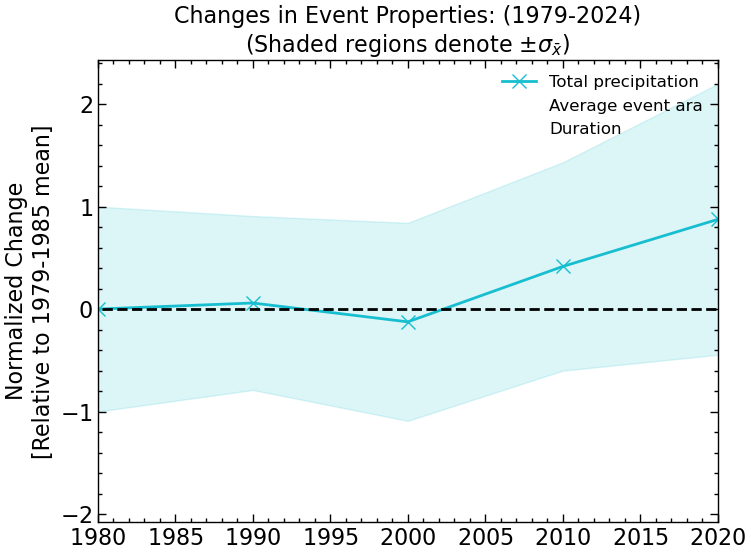

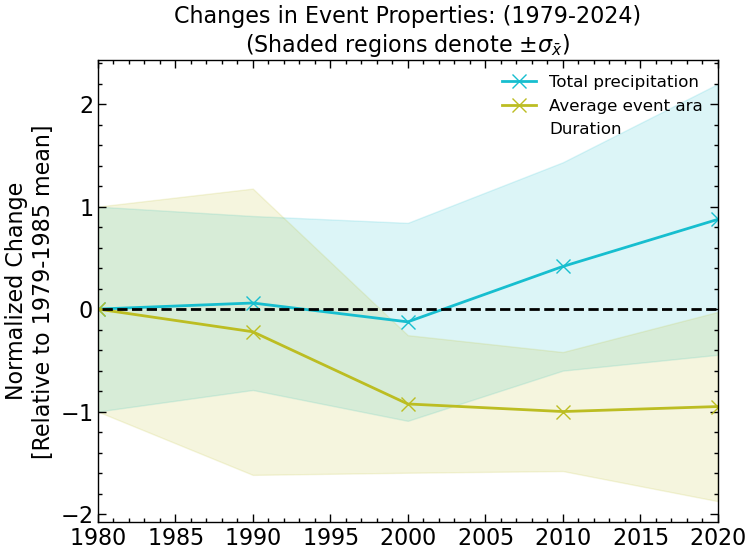

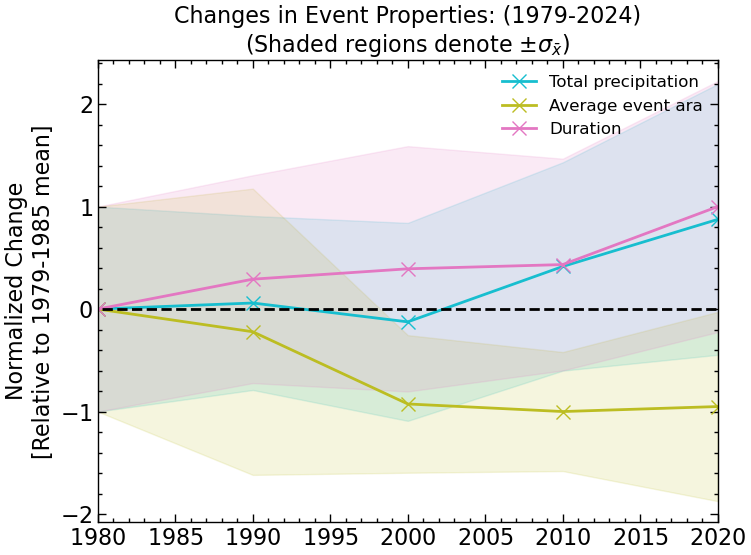

In [6]:
from scipy.interpolate import splrep, splev
# reference = (
#     dfl
#     .filter(pl.col('year') <= 1985)
#     .group_by_dynamic("start_date", every="10y")
#     .agg([
#         # Means
#         pl.count(),
#         pl.col('PPG').mean(),
#         pl.col('TPV').mean(),
#         pl.col('PPD').mean(),
#         pl.col('duration').mean(),
#         pl.col('size').mean(),
#         (pl.col('size').mean()/pl.col('duration').mean()).alias('avg_size'),
#         # Std
#         pl.col('PPG').std().alias('PPG_std'),
#         pl.col('TPV').std().alias('TPV_std'),
#         pl.col('PPD').std().alias('PPD_std'),
#         pl.col('duration').std().alias('duration_std'),
#         pl.col('size').std().alias('size_std'),
#         (pl.col('size').std()/pl.col('duration').std()).alias('avg_size_std'),
#     ])
#     .with_columns([pl.col('start_date').dt.year().alias('year')])
# )
yearly = (
    dfl
    # Set all 1979 points to 1980 just so 10 year binning works properly
    .with_columns(pl.when(pl.col('year') == 1979).then(1980).otherwise(pl.col('year')).alias('year'))
    .with_columns(pl.col('year').cast(pl.Utf8).str.strptime(pl.Date, "%Y").alias('year_date'))
    .sort('year_date')
    .group_by_dynamic("year_date", every="10y")
    .agg([
        # Means
        pl.count(),
        pl.col('PPG').mean(),
        pl.col('TPV').mean(),
        pl.col('PPD').mean(),
        pl.col('duration').mean(),
        pl.col('size').mean(),
        (pl.col('size').mean()/pl.col('duration').mean()).alias('avg_size'),
        # Std
        pl.col('PPG').std().alias('PPG_std'),
        pl.col('TPV').std().alias('TPV_std'),
        pl.col('PPD').std().alias('PPD_std'),
        pl.col('duration').std().alias('duration_std'),
        pl.col('size').std().alias('size_std'),
        (pl.col('size').std()/pl.col('duration').std()).alias('avg_size_std'),
    ])
    .with_columns([pl.col('year_date').dt.year().alias('year')])
)
labels = {
    'PPG': 'Accumulated Pr [per grid]',
    'TPV': 'Total precipitation',
    'PPD': 'Accumulated Pr [per day]',
    'duration': 'Duration',
    'avg_size': 'Average event ara',
}
already_done = []
# years = [1985, 1995, 2005, 2015, 2024]
for i, variable in enumerate(['TPV', 'avg_size', 'duration',]):
    already_done.append(variable)
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    for c, v in zip(['tab:cyan','tab:olive', 'tab:pink'],['TPV', 'avg_size', 'duration',]):
        if v in already_done:
            alpha = 1
        else:
            alpha = 0
        error_alpha = alpha * 0.15
        # Plot means
        new_y = yearly[v]
        anomaly = (new_y-new_y[0])/(new_y.max()-new_y.min())
        ax.plot(yearly['year'], anomaly, label=labels[v], color=c, marker='x', markersize=10, alpha=alpha)
        # Add error barss
        std_y = yearly[v+'_std']/np.sqrt(yearly['count'])
        anomaly_std = std_y/std_y[0]
        ax.fill_between(yearly['year'], (anomaly-anomaly_std), (anomaly+anomaly_std), color=c, alpha=error_alpha)
    ax.legend(fontsize=12)
    ax.set_ylabel('Normalized Change\n[Relative to 1979-1985 mean]')
    ax.hlines(0, 1970, 2025, color='k', linestyle='--')
    ax.set_xlim(1980, 2020)
    ax.set_title('Changes in Event Properties: (1979-2024)\n(Shaded regions denote '+r'$\pm \sigma_{\bar{x}}$)')
    plt.savefig(f'../../output/figures/anomalies_{i}.png', dpi=300, bbox_inches='tight')
    plt.show()

## Types of events

If Tropical Cyclone: don't check for anything else.

In [7]:
def event_hierarchy(is_TC: bool, is_SurfaceFront, is_Thunderstorm):
    if not is_TC and not is_SurfaceFront and not is_Thunderstorm:
        return '???'
    elif is_TC:
        return 'TC'
    elif is_SurfaceFront and is_Thunderstorm:
        return 'SF/Thunder'
    elif is_SurfaceFront:
        return 'SF'
    if is_Thunderstorm:
        return 'Thunderstorms'
    return None

event_df = (
    pl.read_csv('../../data/classified_events.csv')
    .rename({'event_id':'event'})
    .filter(
        (pl.col('start_lat') > -66) & 
        (pl.col('start_lat') < 70) & 
        (pl.col('duration_days') > -20)
    )
)
classifications = event_df.map_rows(lambda row: event_hierarchy(row[-3], row[-2], row[-1])).rename({'map':'event_hierarchy'})
classified_events = event_df.with_columns(classifications)
n_classified_events = len(classified_events)
print(f'n={n_classified_events}')
classified_events

n=84


event,start_date,duration_days,start_lon,start_lat,is_TC,is_SurfaceFront,is_Thunderstorm,event_hierarchy
i64,f64,i64,f64,f64,bool,bool,bool,str
1846,1.3235e18,-7,298.0,17.75,false,true,true,"""SF/Thunder"""
2291,1.3243e18,-9,80.5,7.25,false,true,false,"""SF"""
3832,1.3268e18,-13,40.75,-15.25,false,true,true,"""SF/Thunder"""
6041,1.3302e18,-6,134.5,-31.0,false,true,false,"""SF"""
6665,6.4005e17,-8,138.25,-21.25,false,true,false,"""SF"""
6977,9.8634e17,-6,169.0,-12.25,false,true,false,"""SF"""
7099,6.4074e17,-6,140.5,42.5,false,true,false,"""SF"""
8767,6.4299e17,-7,131.5,-24.25,false,true,false,"""SF"""
10223,2.9972e17,-5,130.75,32.75,false,true,true,"""SF/Thunder"""


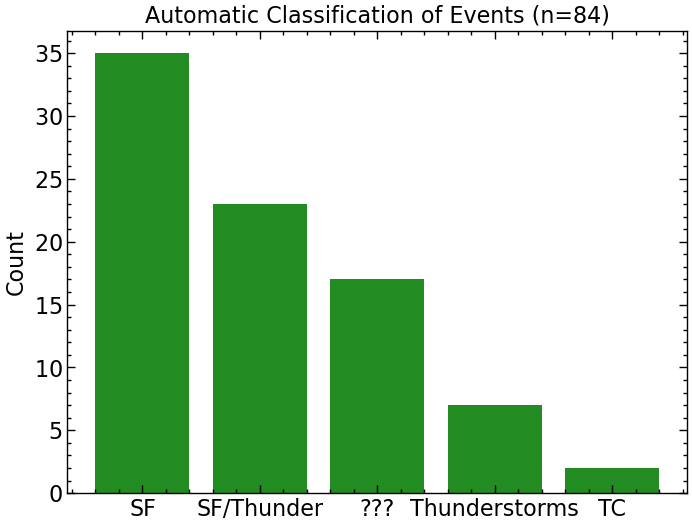

In [8]:
event_by_type = classified_events.group_by('event_hierarchy').count().sort('count', descending=True)
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.bar(event_by_type['event_hierarchy'], event_by_type['count'], color='forestgreen')
ax.set_ylabel('Count')
ax.set_title(f'Automatic Classification of Events (n={n_classified_events})')
# ax.set_xticklabels(event_by_type['event_hierarchy'], rotation=30)
plt.savefig(f'../../output/figures/classification_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

## Plot examples of each

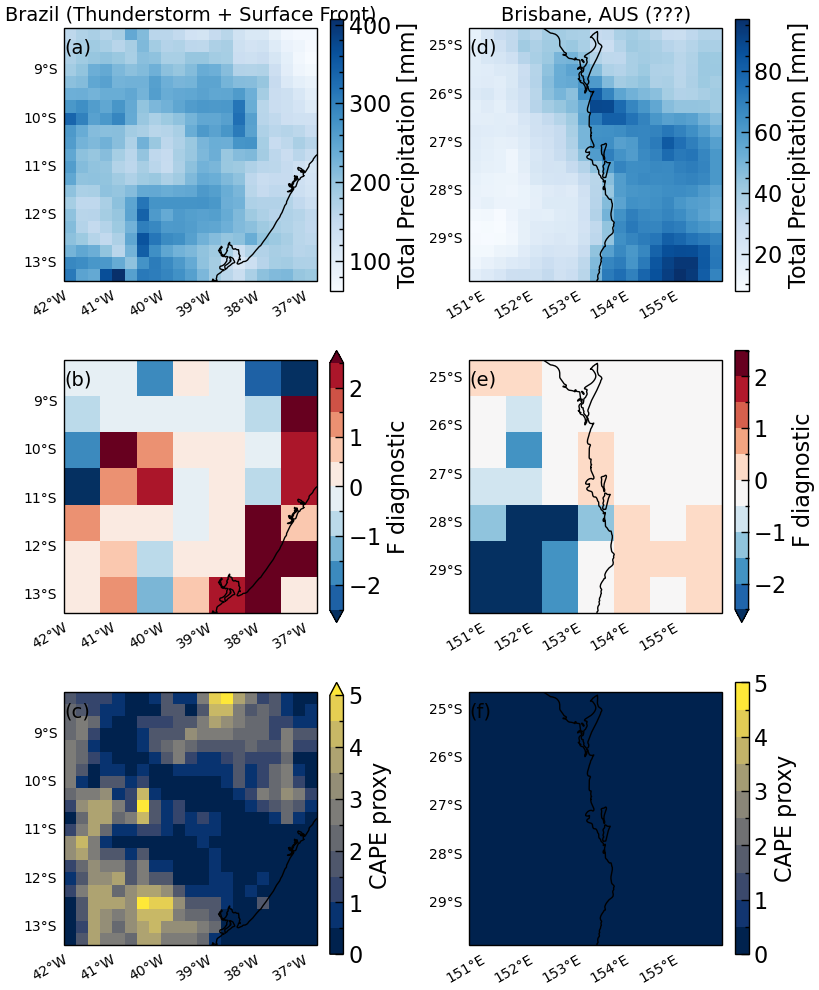

In [9]:
import string
fig = plt.figure(figsize=(8, 10), constrained_layout=True)
gs = fig.add_gridspec(nrows=3, ncols=2)
n = 0
axes = []
for i, id in enumerate([22544, 13428]):
    # 1 - Precipitation
    ax = fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree())
    axes.append(ax)
    pr = xr.load_dataset(f'../../data/precip-events-ERA5/{id}.nc').total_precipitation_6hr.sum('time')*1000
    # pr = pr.where(pr > 0, drop=True)#.rename()
    pr.plot(
        ax=ax,
        cmap = 'Blues', #vmin=50, vmax=400, levels=11,
        cbar_kwargs={'label': 'Total Precipitation [mm]', 'shrink':0.9},
    )
    if i == 0:
        ax.set_title('Brazil (Thunderstorm + Surface Front)', fontsize=14)
    else:
        ax.set_title('Brisbane, AUS (???)', fontsize=14)
    # 2 - F-star
    ax = fig.add_subplot(gs[1, i], projection=ccrs.PlateCarree())
    axes.append(ax)
    F_star = xr.load_dataset(f'../../data/F-star/{id}.nc').F_star
    F_star.plot(
        ax=ax,
        cmap = 'RdBu_r', vmin=-2.5,vmax = 2.5, levels=11,
        cbar_kwargs={'label': 'F diagnostic', 'shrink':0.9},
    )
    ax.set_title('')
    # 3 - CAPE_proxy
    ax = fig.add_subplot(gs[2, i], projection=ccrs.PlateCarree())
    axes.append(ax)
    CAPE_p = xr.load_dataset(f'../../data/CAPE-proxy/{id}.nc').CAPE_proxy
    CAPE_p = CAPE_p.where(CAPE_p >= 0, 0)
    CAPE_p.plot(
        ax=ax,
        cmap = 'cividis', vmax = 5, levels=11,
        cbar_kwargs={'label': 'CAPE proxy', 'shrink':0.9, 'extend': None},
    )
    ax.set_title('')

for ax in axes:
    ax.text(0, 0.9, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=14)
    n+=1
    ax.add_feature(cfeature.COASTLINE)
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True, which='both',
        linewidth=1, color='k', alpha=1, linestyle='--'
        )
    gl.right_labels = None
    gl.top_labels = None
    gl.xlines = None
    gl.ylines = None
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # Increase the ticksize
    gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
    gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}
plt.savefig(f'../../output/figures/sucess_v_failure_comparison.png', dpi=300, bbox_inches='tight')
plt.show()